In [8]:
using CairoMakie, JLD2, Measurements, ScalingCollapse, ColorSchemes
using Measurements: value, uncertainty

In [9]:
colorsblue = [ColorSchemes.Blues_6[i] for i in 2:6]
colorsred = [ColorSchemes.Reds_5[i] for i in 2:5];

In [10]:
# lets define a theme for the figure!
theme = Theme(
    figure_padding=2,
    size=(246, 246),
    fontsize=8,
    Scatter=(
        markersize=4.0,
        strokewidth=0.15,
        marker=:circle,
        strokecolor=(:black, 0.5),
    ),
    Errorbars=(
        linewidth=0.35,
        whiskerwidth=2.0,
        color=:black,
    ),
    Axis=(
        titlefont=:regular,
        titlesize=10,
        xlabelsize=10,
        ylabelsize=10,
        xgridvisible=false,
        ygridvisible=false,
        xticksize=2.5,
        yticksize=2.5,
        xminorticksize=1.5,
        yminorticksize=1.5,
        spinewidth=0.75,
        xtickwidth=0.75,
        ytickwidth=0.75,
    ),
    Legend=(
        labelfont=:regular,
        padding=(2, 2, 2, 2), # The additional space between the legend content and the border.
        patchlabelgap=3, # The gap between the patch and the label of each legend entry.
        patchsize=(4, 4), # The size of the rectangles containing the legend markers.
        rowgap=0, # The gap between the entry rows.
        colgap=0, # The gap between the entry columns.
        titlefont=:regular,
        titlegap=1,
        margin=(2, 2, 2, 2),
        framevisible=false,
    ),
)

# merge the theme with the theme_latexfonts() and update the theme
theme = merge(theme, theme_latexfonts())
update_theme!(theme)

In [11]:
# this scales the size of the rendered figure in the notebook by 1.75
CairoMakie.activate!(type="svg", pt_per_unit=1.75)

In [12]:
# load example data
file = jldopen("data/plotdata.jld2", "r")
xs1 = file["xs1"]
ys1msm = file["ys1"]

ys1 = [
    value.(ys1msm[i]) for i in eachindex(ys1msm)
]
ys1err = [
    uncertainty.(ys1msm[i]) for i in eachindex(ys1msm)
]

ds1 = file["ds1"]
xs2 = file["xs2"]
ys2msm = file["ys2"]
ys2 = [
    value.(ys2msm[i]) for i in eachindex(ys2msm)
]
ys2err = [
    uncertainty.(ys2msm[i]) for i in eachindex(ys2msm)
]
ds2 = file["ds2"]
close(file)

In [13]:
function get_BBox(axis; width = 50, height = 50, position = :rt, margin = (3, 3, 3, 3))
	# Get the axis position
	ax_pos = axis.layoutobservables.computedbbox[]

	# Calculate the position based on the specified corner
	if position == :rt  # right top
		x = ax_pos.origin[1] + ax_pos.widths[1] - width - margin[2]
		y = ax_pos.origin[2] + ax_pos.widths[2] - height - margin[1]
	elseif position == :lt  # left top
		x = ax_pos.origin[1] + margin[4]
		y = ax_pos.origin[2] + ax_pos.widths[2] - height - margin[1]
	elseif position == :rb  # right bottom
		x = ax_pos.origin[1] + ax_pos.widths[1] - width - margin[2]
		y = ax_pos.origin[2] + margin[3]
	elseif position == :lb  # left bottom
		x = ax_pos.origin[1] + margin[4]
		y = ax_pos.origin[2] + margin[3]
	end

	return BBox(x, x + width, y, y + height)
end

get_BBox (generic function with 1 method)

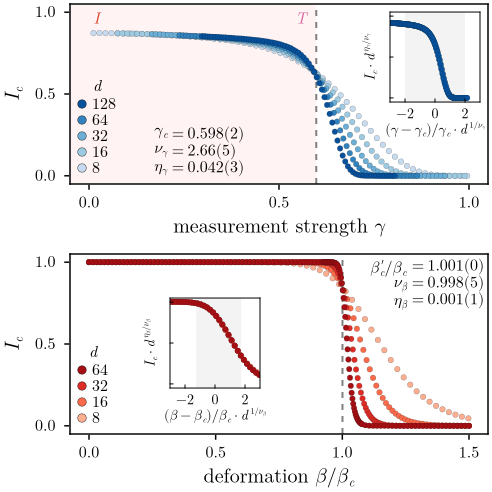

In [14]:
fig = Figure()
ax1 = Axis(fig[1, 1],
	xlabel = L"\text{measurement strength } \gamma",
	ylabel = L"I_c",
	limits = ((-0.05, 1.05), (-0.05, 1.05)),
)
ax2 = Axis(fig[2, 1],
	xlabel = L"\text{deformation } \beta/\beta_c",
	ylabel = L"I_c",
	limits = (nothing, (-0.05, 1.05)),
)

rowgap!(fig.layout, 10.0)

for (i, d) in enumerate(ds1)
	scatter!(ax1, xs1[i], ys1[i], color = colorsblue[i])
end

for (i, d) in enumerate(ds2)
	scatter!(ax2, xs2[i], ys2[i], color = colorsred[i])
end

# subplot top axis
begin
	subbox = get_BBox(
		ax1,
		width = 45,
		height = 45,
		position = :rt,
		margin = (4, 4, 4, 4),
	)

	bg = poly!(fig.scene,
		subbox,
		color = :white,
	)

	# move the background behind all content (excluding gridlines which are at -10)
	translate!(bg, 0, 0, -9)

	axsub = Axis(fig;
		bbox = subbox,
		ylabelvisible = true,
		yticklabelsvisible = false,
		xlabel = L"(\gamma-\gamma_c) / \gamma_c \cdot d^{\: 1/ \nu_\gamma}",  # \frac{t-t_c}{t_c} \cdot d^{1/ \nu}
		ylabel = L"I_c \cdot d^{\: \eta_\gamma / \nu_\gamma}",
		yticks = ([0, 1, 1 / 2], [L"0.0", L"1.0", L"0.5"]),
		xticks = LinearTicks(3),
		xlabelsize = 7,
		ylabelsize = 7,
		xticklabelsize = 7,
		yticklabelsize = 7,
		xlabelpadding = 0.0,
		xtickalign = 1,
		ytickalign = 1,
		yticklabelpad = 2,
		limits = ((-3, 3), (-1 / 20, 1 * 21 / 20)),
		spinewidth = 0.5,
		xticksize = 2,
		yticksize = 2,
		xtickwidth = 0.5,
		ytickwidth = 0.5,
	)
	# move the subaxis gridline before the background!
	translate!(axsub.elements[:xgridlines], 0, 0, -8)
	translate!(axsub.elements[:ygridlines], 0, 0, -8)


	### doing the scaling collapse and plotting
	begin
		# scaling collapse for the first dataset
		sp1 = ScalingProblem(
			xs1,
			ys1,
			ys1err,
			ds1;
			sf = ScalingFunction(:xy),
			dx = [-2, 2],
			p_space = [0.3:0.1:0.9, 1.0:0.1:5.0, 0.0:0.01:0.1],
			quality = MultipleSplines(),
		)

		# get the scaled data
		sx, sy, se, sL = scaled_data(sp1)
		for (l, L) in enumerate(sL)
			xs = sx[l]
			ys = sy[l]
			yerrs = se[l]
			scatter!(axsub, xs, ys, color = colorsblue[l], strokewidth = 0.1)
		end
		vs_1 = vspan!(axsub, [sp1.dx[1]], [sp1.dx[2]], color = (:black, 0.05))
		translate!(vs_1, 0, 0, -8)
	end

end

# subplot bottom axis
begin
	subbox = get_BBox(
		ax2,
		width = 45,
		height = 45,
		position = :lb,
		margin = (20, 20, 23, 50.2),
	)

	bg = poly!(fig.scene,
		subbox,
		color = :white,
	)
	translate!(bg, 0, 0, -9) # bg behind patches but before content at 0 (legend is at +10)
	
    axsub = Axis(fig;
		bbox = subbox,
		ylabelvisible = true,
		yticklabelsvisible = false,
		xlabel = L"(\beta-\beta_c) / \beta_c \cdot d^{\: 1/ \nu_\beta}",
		ylabel = L"I_c \cdot d^{\: \eta_\beta / \nu_\beta}",
		yticks = ([0, 1, 1 / 2], [L"0", L"1", L"\frac{1}{2}"]),
		xticks = LinearTicks(3),
		xlabelsize = 7,
		ylabelsize = 7,
		xticklabelsize = 7,
		yticklabelsize = 7,
		xlabelpadding = 0.0,
		xtickalign = 1,
		ytickalign = 1,
		yticklabelpad = 2,
		limits = ((-3, 3), (-1 / 20, 1 * 21 / 20)),
		spinewidth = 0.5,
		xticksize = 2,
		yticksize = 2,
		xtickwidth = 0.5,
		ytickwidth = 0.5,
	)
	translate!(axsub.elements[:xgridlines], 0, 0, -8)
	translate!(axsub.elements[:ygridlines], 0, 0, -8)

	begin
		sp2 = ScalingProblem(
			xs2,
			ys2,
            ys2err,
            ds2;
			sf = ScalingFunction(:xy),
			p_space = [0.6:0.01:1.3, 0.5:0.1:1.5, -0.5:0.1:0.5],
			dx = [-1.25, 1.75],
			quality = MultipleSplines(N_steps = 100),
		)
		sx, sy, se, sL = scaled_data(sp2)

		for (l, L) in enumerate(sL)
			xs = sx[l]
			ys = sy[l]
			yerrs = se[l]
			scatter!(axsub, xs, ys, color = colorsred[l], strokewidth = 0.1)
		end
		vs_2 = vspan!(axsub, [sp2.dx[1]], [sp2.dx[2]], color = (:black, 0.05))
		translate!(vs_2, 0, 0, -8)
	end
end

for (ax, ds, colors) in zip([ax1, ax2], [ds1, ds2], [colorsblue, colorsred])
	axislegend(
		ax,
		reverse([
			MarkerElement(
				color = colors[i], markersize = 6,
				marker = :circle,
				strokewidth = 0.2,
			) for i in eachindex(ds)
		]),
		reverse(["$d" for d in ds]),
		L"d",
		position = :lb,
		margin = (2, 2, 2, 2),
	)
end


vs = vspan!(ax1, [-1], [sp1.optimal_ps[1]], color=(1, 0, 0, 0.05))
translate!(vs, 0, 0, -11)

text!(ax1, 0.02, 0.96; text=L"I", fontsize=8, color="#DC3F29", align=(:center, :center))
text!(ax1, sp1.optimal_ps[1] - 0.04, 0.96; text=L"T", fontsize=8, color="#D8629E", align=(:center, :center))

vl1 = vlines!(ax1, [sp1.optimal_ps[1]], color=:gray, linewidth=1, linestyle=:dash)
vl2 = vlines!(ax2, [sp2.optimal_ps[1]], color=:gray, linewidth=1, linestyle=:dash)
translate!(vl1, 0, 0, -8)
translate!(vl2, 0, 0, -8)


axislegend(
    ax1,
    [MarkerElement(color=(:white, 0.0), markersize=0.0, marker=:circle) for _ in 1:3],
    [
        L"\gamma_c",
        L"\nu_\gamma ",
        L"\eta_\gamma ",
    ];
    position=:lb,
    margin=(33, 2, 2, 20),
)
axislegend(
    ax1,
    [MarkerElement(color=(:white, 0.0), markersize=0.0, marker=:circle) for _ in 1:3],
    [
        L"= 0.598(2)",
        L"= 2.66(5)",
        L"= 0.042(3)",
    ];
    position=:lb,
    margin=(42, 2, 2, 20),
)
axislegend(
    ax2,
    [MarkerElement(color=(:white, 0.0), markersize=0.0, marker=:circle) for _ in 1:3],
    [
        L"\beta_c' / \beta_c", 
        " ",
        " ",
        ];
    position=:rt,
    margin=(0, 38.5, 0, 0),
)
axislegend(
    ax2,
    [MarkerElement(color=(:white, 0.0), markersize=0.0, marker=:circle) for _ in 1:3],
    [
        " ", 
        L"\nu_\beta",
        L"\eta_\beta",
        ];
    position=:rt,
    margin=(0, 38.5, 0, 0),
)
axislegend(
    ax2,
    [MarkerElement(color=(:white, 0.0), markersize=0.0, marker=:circle) for _ in 1:3],
    [
        L"= 1.001(0)", 
        L"= 0.998(5)",
        L"= 0.001(1)",
        ];
    position=:rt,
    margin=(0, 0, 0, 0),
)
fig
